### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score, cross_validate, ShuffleSplit
import matplotlib.pyplot as plt
from sklearn.metrics import auc, RocCurveDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import re

### Loading files

In [ ]:
mpa = pd.read_csv('data/1_taxonomic_annotation/metaphlan.tsv', sep='\t', index_col=0) # metaphlan table
kegg = pd.read_csv('data/2_functional_annotation/humann2-KEGG.tsv', sep='\t', index_col=0) # kegg orthology table
mags = pd.read_csv('data/3_genomes/mags.tsv', sep='\t', index_col=0) # mags table

meta = pd.read_csv('data/metadata.tsv', sep ='\t', index_col=0) # metadata 
mags_meta = meta.drop(['SRR16554661', 'SRR16554629']) # mags table  for some reason has 2 less entries than others

y_true = meta['response'].astype("category").cat.codes # encoding variable with immunotherapy response 
mags_y_true = mags_meta['response'].astype("category").cat.codes

mags_names = pd.read_csv('data/3_genomes/taxonomy.tsv', sep='\t') # for annotation

In [ ]:
# Metahlan tables were corrected with ConQuR using different batches as references.

mpa_baruch = pd.read_csv('data/1_taxonomic_annotation/mpa_corrected/mpa.corrected_Baruch_2021.csv', index_col=0)
mpa_davar = pd.read_csv('data/1_taxonomic_annotation/mpa_corrected/mpa.corrected_Davar_2021.csv', index_col=0)
mpa_frankel = pd.read_csv('data/1_taxonomic_annotation/mpa_corrected/mpa.corrected_Frankel_2017.csv', index_col=0)
mpa_gop = pd.read_csv('data/1_taxonomic_annotation/mpa_corrected/mpa.corrected_Gopalakrishnan_2019.csv', index_col=0)
mpa_lee = pd.read_csv('data/1_taxonomic_annotation/mpa_corrected/mpa.corrected_Lee_2022.csv', index_col=0)
mpa_matson = pd.read_csv('data/1_taxonomic_annotation/mpa_corrected/mpa.corrected_Matson_2019.csv', index_col=0)
mpa_spencer = pd.read_csv('data/1_taxonomic_annotation/mpa_corrected/mpa.corrected_Spencer_2021.csv', index_col=0)

In [ ]:
# MAGs tables were corrected with ConQuR using different batches as references.

mags_baruch = pd.read_csv('data/3_genomes/mags_corrected/mags.corrected_Baruch_2021.csv', index_col=0)
mags_davar = pd.read_csv('data/3_genomes/mags_corrected/mags.corrected_Davar_2021.csv', index_col=0)
mags_frankel = pd.read_csv('data/3_genomes/mags_corrected/mags.corrected_Frankel_2017.csv', index_col=0)
mags_gop = pd.read_csv('data/3_genomes/mags_corrected/mags.corrected_Gopalakrishnan_2019.csv', index_col=0)
mags_lee = pd.read_csv('data/3_genomes/mags_corrected/mags.corrected_Lee_2022.csv', index_col=0)
mags_matson = pd.read_csv('data/3_genomes/mags_corrected/mags.corrected_Matson_2019.csv', index_col=0)
mags_spencer = pd.read_csv('data/3_genomes/mags_corrected/mags.corrected_Spencer_2021.csv', index_col=0)

In [ ]:
# KO tables were corrected with ConQuR using different batches as references.

kegg_baruch = pd.read_csv('data/2_functional_annotation/kegg_corrected/kegg.corrected_Baruch_2021.csv', index_col=0)
kegg_davar = pd.read_csv('data/2_functional_annotation/kegg_corrected/kegg.corrected_Davar_2021.csv', index_col=0)
kegg_frankel = pd.read_csv('data/2_functional_annotation/kegg_corrected/kegg.corrected_Frankel_2017.csv', index_col=0)
kegg_gop = pd.read_csv('data/2_functional_annotation/kegg_corrected/kegg.corrected_Gopalakrishnan_2019.csv', index_col=0)
kegg_lee = pd.read_csv('data/2_functional_annotation/kegg_corrected/kegg.corrected_Lee_2022.csv', index_col=0)
kegg_matson = pd.read_csv('data/2_functional_annotation/kegg_corrected/kegg.corrected_Matson_2019.csv', index_col=0)
kegg_spencer = pd.read_csv('data/2_functional_annotation/kegg_corrected/kegg.corrected_Spencer_2021.csv', index_col=0)

ConQuR works with read count data, but original data is frequency tables, so for compatibility counts are transformed into frequencies.

In [ ]:
mpa_corr = mpa_davar.div(mpa_davar.sum(axis=1), axis=0).drop(['SRR16554661', 'SRR16554629'])
kegg_corr = kegg_davar.div(kegg_davar.sum(axis=1), axis=0).drop(['SRR16554661', 'SRR16554629'])
mags_corr = mags_davar.div(mags_davar.sum(axis=1), axis=0)

In [ ]:
# The only feature engineering step leading to improved scores and easier interpretation of results is filtering out phages and other viruses.
mpa_corr_filtered = mpa_corr.drop(mpa_corr.filter(regex='phage').columns, axis=1)
mpa_corr_filtered = mpa_corr_filtered.drop(mpa_corr_filtered.filter(regex='virus').columns, axis=1)

mpa_filtered = mpa.drop(mpa.filter(regex='phage').columns, axis=1)
mpa_filtered = mpa_filtered.drop(mpa_filtered.filter(regex='virus').columns, axis=1)

Concatenating different tables into united dataset 

In [ ]:
dfs = [mpa_filtered.drop(['SRR16554661', 'SRR16554629']), kegg.drop(['SRR16554661', 'SRR16554629']), mags]
dfs_corr = [mpa_corr_filtered, kegg_corr, mags_corr]

In [ ]:
united = pd.concat(dfs, axis=1)
united_corr = pd.concat(dfs_corr, axis=1)

Fold and groups for 6-vs-1 testing

In [ ]:
fold = GroupKFold(n_splits=7)
groups = meta.dataset
mags_groups = mags_meta.dataset

### Model validation

There was a lot of experiments with Random forest, but none of them has improved scores. We came to the conclusion that untuned RandomForestClassifier is the best option due to its simplicity and high (actually, the best) performance compared to pipelines with PCA, feature selection etc. 

In [ ]:
mpa_scores=[]
names = []
kegg_scores = []
mags_scores = []
uni_scores = []

# Metaphlan

# Splitting the data according group K fold assigned earlier
for train, test in fold.split(groups=groups, X=mpa_filtered, y=y_true):
    # train test split
    X = mpa_filtered
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y_true.iloc[train]
    y_test = y_true.iloc[test]
    
    #model fitting
    rfc = RandomForestClassifier(random_state=13, n_estimators = 999)
    rfc.fit(X_train, y_train)
    
    #writing scores
    pred = rfc.predict_proba(X_test)[:, 1]
    mpa_roc = roc_auc_score(y_test, pred)
    mpa_scores.append(mpa_roc)
    
    # writing current testing dataset
    dataset = np.unique(meta.iloc[test].dataset)
    names.append(dataset[0])

for train, test in fold.split(groups=groups, X=kegg, y=y_true):

    X = kegg
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train =y_true.iloc[train]
    y_test =y_true.iloc[test]
    rfc = RandomForestClassifier(random_state=13, n_estimators = 999)

    rfc.fit(X_train, y_train)
    pred = rfc.predict_proba(X_test)[:, 1]
    kegg_roc = roc_auc_score(y_test, pred)
    kegg_scores.append(kegg_roc)

for train, test in fold.split(groups=mags_groups, X=mags, y=mags_y_true):

    X = mags
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = mags_y_true.iloc[train]
    y_test = mags_y_true.iloc[test]
    rfc =	RandomForestClassifier(random_state=13, n_estimators = 999)

    rfc.fit(X_train, y_train)
    pred = rfc.predict_proba(X_test)[:, 1]
    mags_roc = roc_auc_score(y_test, pred)
    mags_scores.append(mags_roc)

for train, test in fold.split(groups=mags_groups, X=united, y=mags_y_true):

    X = united
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = mags_y_true.iloc[train]
    y_test = mags_y_true.iloc[test]
    rfc = RandomForestClassifier(random_state=13, n_estimators = 999)

    rfc.fit(X_train, y_train)
    pred = rfc.predict_proba(X_test)[:, 1]
    uni_roc = roc_auc_score(y_test, pred)
    uni_scores.append(uni_roc)
    
# 5 Fold shuffle split CV

names.append('5-fold CV')
shuffle = ShuffleSplit(n_splits = 5, random_state=13)
rfc = RandomForestClassifier(random_state=13, n_estimators = 999)

mpa_cv = cross_val_score(rfc, mpa_filtered,y_true, cv=shuffle, scoring='roc_auc').mean()
kegg_cv = cross_val_score(rfc, kegg,y_true, cv=shuffle, scoring='roc_auc').mean()
mags_cv = cross_val_score(rfc, mags, mags_y_true, cv=shuffle, scoring='roc_auc').mean()
uni_cv = cross_val_score(rfc, united, mags_y_true, cv=shuffle, scoring='roc_auc').mean()

# 5 Fold shuffle split CV on the datasets with corrected batch effect

names.append('5-fold CV, BE corrected')
mpa_corr_cv = cross_val_score(rfc, mpa_corr, mags_y_true, cv=shuffle, scoring='roc_auc').mean()
kegg_corr_cv = cross_val_score(rfc, kegg_corr, mags_y_true, cv=shuffle, scoring='roc_auc').mean()
mags_corr_cv = cross_val_score(rfc, mags_corr, mags_y_true, cv=shuffle, scoring='roc_auc').mean()
uni_corr_cv	= cross_val_score(rfc, united_corr, mags_y_true, cv=shuffle, scoring='roc_auc').mean()


mpa_scores.append(mpa_cv)
kegg_scores.append(kegg_cv)
mags_scores.append(mags_cv)
uni_scores.append(uni_cv)

mpa_scores.append(mpa_corr_cv)
kegg_scores.append(kegg_corr_cv)
mags_scores.append(mags_corr_cv)
uni_scores.append(uni_corr_cv)

heat_df = pd.DataFrame({'Tested on': names, 'MPA': mpa_scores, 'MAGs': mags_scores, 'KEGG2': kegg_scores, 'United': uni_scores}).set_index('Tested on')

Plotting scores

[Text(0.5, 1.0, 'ROC AUCs, 6 vs 1 testing and CV')]

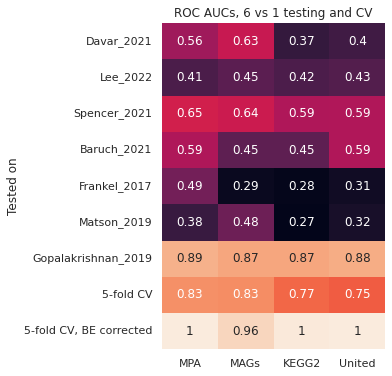

In [ ]:
sns.set(rc={'figure.figsize':(4,6)})
sns.heatmap(heat_df, annot=True, cbar=False).set(title='ROC AUCs, 6 vs 1 testing and CV')

ROC-AUC plots

/tmp/ipykernel_36950/2000103943.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)", color = 'r', lw=2)


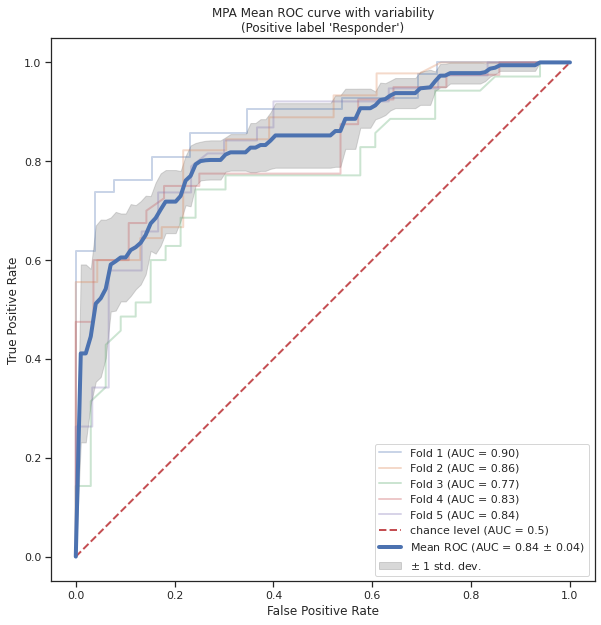

/tmp/ipykernel_36950/2000103943.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)", color = 'r', lw=2)


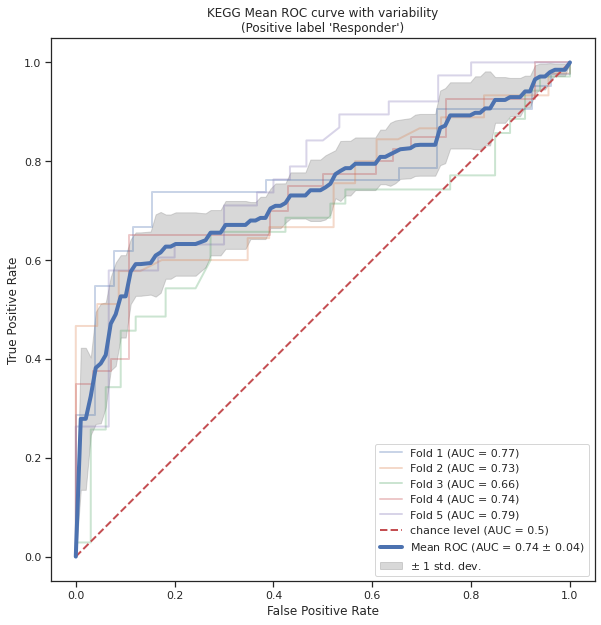

/tmp/ipykernel_36950/2000103943.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)", color = 'r', lw=2)


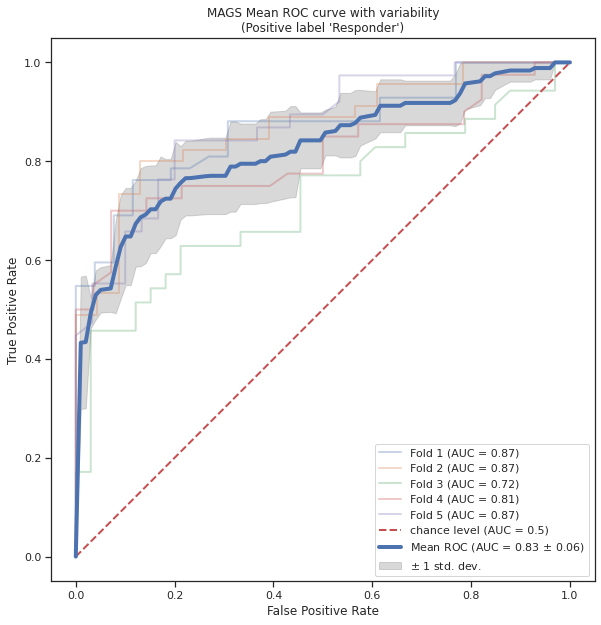

In [ ]:
titles = ['MPA', 'KEGG', 'MAGS']
for i in range(3):
    X = dfs[i]
    y = y_true if len(dfs[i]) == 680 else mags_y_true

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(10, 10))
    for fold, (train, test) in enumerate(shuffle.split(X, y)):
        classifier = RandomForestClassifier(n_estimators=999, random_state=13)

        classifier.fit(X.iloc[train], y.iloc[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X.iloc[test],
            y.iloc[test],
            name=f"Fold {fold+1}",
            alpha=0.3,
            lw=2,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)", color = 'r', lw=2)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=4,
        alpha=1,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.3,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"{titles[i]} Mean ROC curve with variability\n(Positive label 'Responder')",
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    plt.show()

### Statistics
We performed Mann-Whitney test with multiple comparsions correction for every bacteria in uncorrected Metaphlan data. Results are odd and hard to interpret, so just for report, it will be here. 

In [ ]:
stats = pd.DataFrame({'Bacteria': mpa_filtered.columns}) #empty df
names = np.unique(meta.dataset) #datasets names 
datasets = [mpa_filtered[meta.dataset == i] for i in names] #divide all samples according to dataset they belong to

for i in range(7):
    # Splitting dataset into R and NR
    r = datasets[i][meta.response == 'R']
    nr = datasets[i][meta.response == 'NR']
    
    # Mann-Whitney test for every bacteria
    mw_greater = [mannwhitneyu(r[bact], nr[bact]) for bact in stats['Bacteria']]
    U = [test.statistic for test in mw_greater]
    pval = [test.pvalue for test in mw_greater]
    
    # P-value correction
    corrected = multipletests(pval, alpha=0.05, method='fdr_bh')
    stats[f'{names[i]}'] = corrected[1]
    stats[f'{names[i]} significant'] = corrected[0]

stats['significant in'] = np.sum(stats.loc[:,::2], axis=1)
stats = stats.set_index('Bacteria')

In [ ]:
# Mean p-value for sorting 
stats['mean'] = stats.drop(stats.filter(regex='significant').columns, axis=1).mean(axis=1)

Plotting statistical data

In [ ]:
stats_heat = stats[stats['significant in'] > 0].sort_values('mean')[0:11].drop(stats.filter(regex='sign').columns, axis=1)

<AxesSubplot:ylabel='Bacteria'>

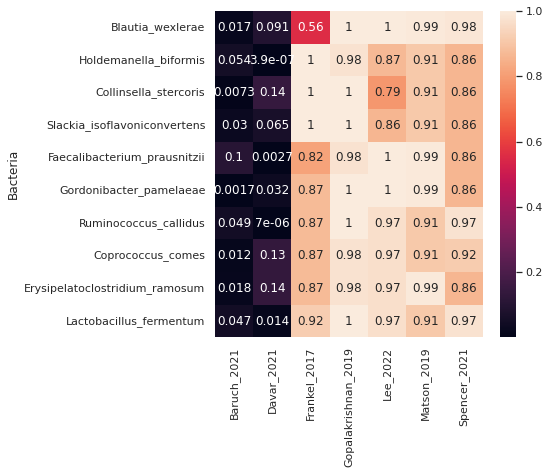

In [ ]:
sns.set(rc={'figure.figsize':(6,6)})

sns.heatmap(stats_heat[:10].drop('mean', axis=1), annot=True)

### Feature extraction
The main goal of the project is to extract most important feature from Random forest model and try to somehow interpret them using the literature. As ve already know how accurate is our model (raw RF), we have not been validating our model when extracting features and have been trained it on the whole datasets - now we are not interested in any scores.

### United dataset

Plotting 

[Text(0, 0.5, 'Feature'), Text(0.5, 0, 'Importance in model')]

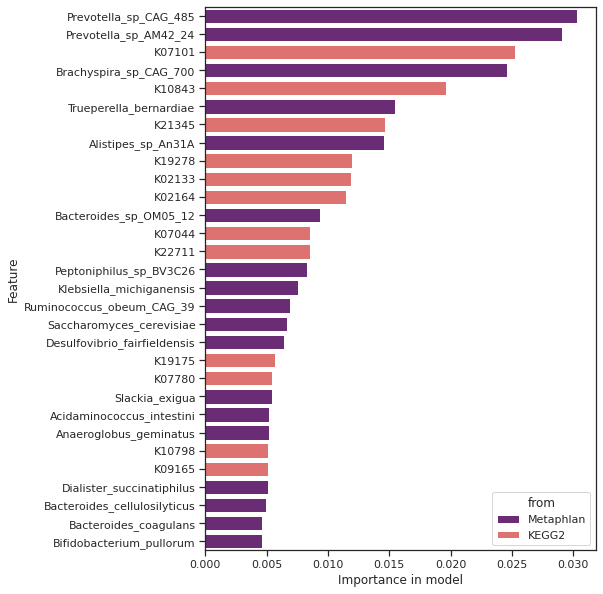

In [ ]:
features = united_corr.columns # list of feature names

# this odd part is to know where each feature is from
fr = [] 
for i in range(747):
  fr.append('Metaphlan')
for i in range(6574):
  fr.append('KEGG2')
for i in range(1422):
  fr.append('MAGs')

united_importance = pd.DataFrame({'Feature':  features})
united_importance['from'] = fr

#Untuned RF, fitting on whole dataset
rfc = RandomForestClassifier(random_state=13, n_estimators=999)
rfc.fit(united_corr, mags_y_true)

united_importance['importance'] = rfc.feature_importances_

#Plotting results (top 30 features)


plot_data = united_importance.sort_values('importance', ascending=False).iloc[:30]
plot_data['importance'] = plot_data['importance']
sns.set(font_scale=2)

sns.set(rc={'figure.figsize':(7,10)})
sns.set_style("ticks")


ax = sns.barplot(x = "importance",
            y = "Feature",
            data = plot_data,
            hue='from',
            dodge=False,
            palette='magma'
            )


ax.set(ylabel='Feature', xlabel='Importance in model')

### Metaphlan

[Text(0, 0.5, 'Feature'), Text(0.5, 0, 'Importance in model')]

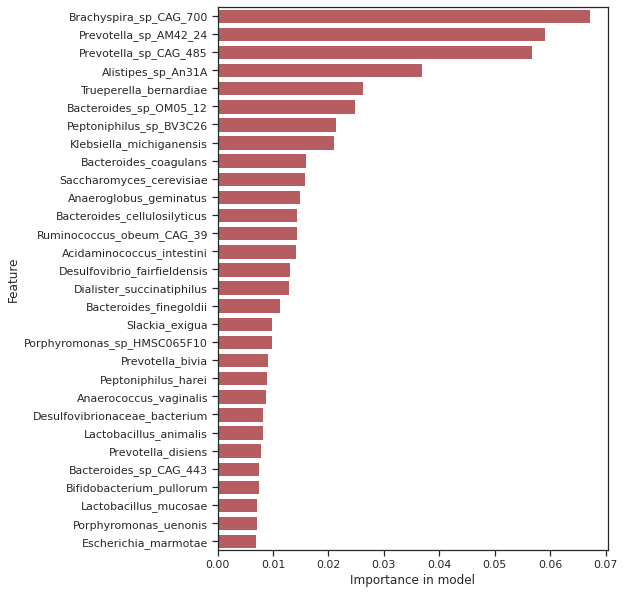

In [ ]:
features = mpa_corr_filtered.columns
mpa_importance = pd.DataFrame({'Feature':  features})


rfc = RandomForestClassifier(random_state=13, n_estimators=999)
rfc.fit(mpa_corr_filtered, mags_y_true)

mpa_importance['importance'] = rfc.feature_importances_

mpa_importance = mpa_importance.drop(mpa_importance[mpa_importance.Feature.str.contains(r'phage')].index)

plot_data = mpa_importance.sort_values('importance', ascending=False).iloc[:30]
plot_data['importance'] = plot_data['importance']
sns.set(font_scale=2)

sns.set(rc={'figure.figsize':(7,10)})
sns.set_style("ticks")


ax = sns.barplot(x = "importance",
            y = "Feature",
            data = plot_data,
            dodge=False,
            color='r'
            )


ax.set(ylabel='Feature', xlabel='Importance in model')

Writing .csv. 

In [ ]:
# Writing .csv
datasets = [mpa_baruch, mpa_davar, mpa_frankel, mpa_gop, mpa_lee, mpa_matson, mpa_spencer]
mpa_importances = pd.DataFrame({'feature': mpa_baruch.columns}).set_index('feature')
for i in range(7):
    
    features = datasets[i].columns
    
    rfc = RandomForestClassifier(random_state=13, n_estimators = 999)
    rfc.fit(datasets[i], y_true)
    
    mpa_importances[names[i]] = rfc.feature_importances_

mpa_importances['mean'] = mpa_importances.sum(axis=1)/7
mpa_importances.sort_values('mean', ascending=False).to_csv('results/mpa_importances.csv')

### KO


[Text(0, 0.5, 'Feature'), Text(0.5, 0, 'Importance in model')]

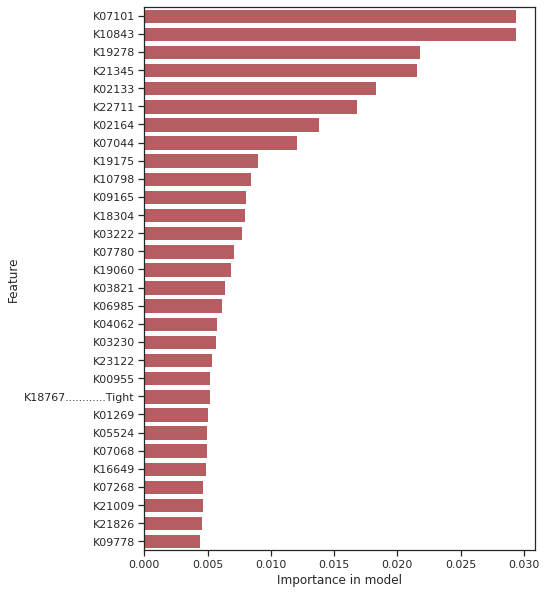

In [ ]:
features = kegg_corr.columns
kegg_importance = pd.DataFrame({'Feature':  features})


rfc = RandomForestClassifier(random_state=13, n_estimators=999)
rfc.fit(kegg_corr, mags_y_true)

kegg_importance['importance'] = rfc.feature_importances_

kegg_importance = kegg_importance.drop(kegg_importance[kegg_importance.Feature.str.contains(r'phage')].index)

plot_data = kegg_importance.sort_values('importance', ascending=False).iloc[:30]
plot_data['importance'] = plot_data['importance']
sns.set(font_scale=2)

sns.set(rc={'figure.figsize':(7,10)})
sns.set_style("ticks")


ax = sns.barplot(x = "importance",
            y = "Feature",
            data = plot_data,
            dodge=False,
            color='r'
            )


ax.set(ylabel='Feature', xlabel='Importance in model')

In [ ]:
# Writing .csv
datasets = [kegg_baruch, kegg_davar, kegg_frankel, kegg_gop, kegg_lee, kegg_matson, kegg_spencer]
kegg_importances = pd.DataFrame({'feature': kegg_baruch.columns}).set_index('feature')
for i in range(7):
    
    features = datasets[i].columns
    
    rfc = RandomForestClassifier(random_state=13, n_estimators = 999)
    rfc.fit(datasets[i], y_true)
    
    kegg_importances[names[i]] = rfc.feature_importances_

kegg_importances['mean'] = kegg_importances.sum(axis=1)/7
kegg_importances.sort_values('mean', ascending=False).to_csv('results/kegg_importances.csv')

### MAGS

[Text(0, 0.5, 'Feature'), Text(0.5, 0, 'Importance in model')]

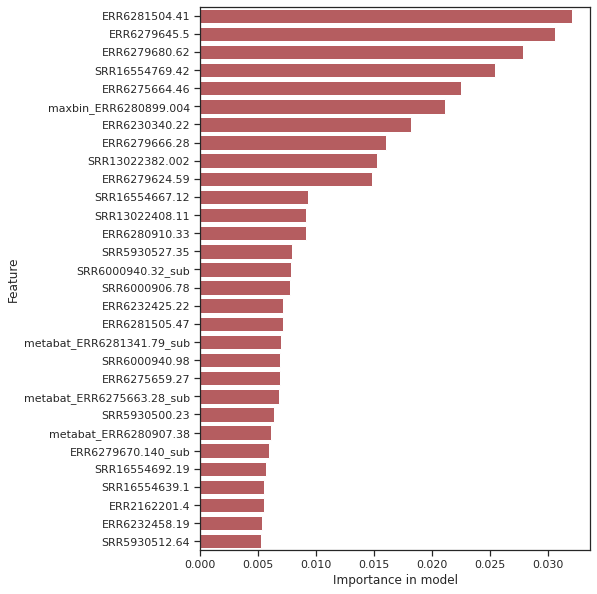

In [ ]:
features = mags_corr.columns
mags_importance = pd.DataFrame({'Feature':  features})


rfc = RandomForestClassifier(random_state=13, n_estimators=999)
rfc.fit(mags_corr, mags_y_true)

mags_importance['importance'] = rfc.feature_importances_

mags_importance = mags_importance.drop(mags_importance[mags_importance.Feature.str.contains(r'phage')].index)

plot_data = mags_importance.sort_values('importance', ascending=False).iloc[:30]
plot_data['importance'] = plot_data['importance']
sns.set(font_scale=2)

sns.set(rc={'figure.figsize':(7,10)})
sns.set_style("ticks")


ax = sns.barplot(x = "importance",
            y = "Feature",
            data = plot_data,
            dodge=False,
            color='r'
            )


ax.set(ylabel='Feature', xlabel='Importance in model')

In [ ]:
#Writing .csv 
datasets = [mags_baruch, mags_davar, mags_frankel, mags_gop, mags_lee, mags_matson, mags_spencer]
mags_importances = pd.DataFrame({'feature': mags_baruch.columns}).set_index('feature')
for i in range(7):
    
    features = datasets[i].columns
    
    rfc = RandomForestClassifier(random_state=13, n_estimators = 999)
    rfc.fit(datasets[i], mags_y_true)
    
    mags_importances[names[i]] = rfc.feature_importances_
mags_importances['mean'] = mags_importances.sum(axis=1)/7

# Annotating MAGS table with taxonomy

mags_annot = [mags_names[mags_names['genome'] == i].taxonomy.iloc[0] for i in mags_importances.index]
mags_annot = [re.search(r's__.*$', i)[0].replace('s__', '') for i in mags_annot]
mags_importances['annotation'] = mags_annot

mags_importances.sort_values('mean', ascending=False).to_csv('results/mags_importances.csv')

### Attempt to annotate KO list. 

Final pie chart was prepared manually.
Result is quite non-informative, so, again, it is here only for report.

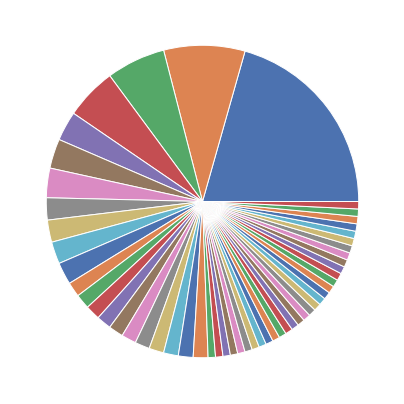

In [ ]:
pathname = pd.read_csv('data/2_functional_annotation/kegg_files/pathway.list', sep='\t', header=1)
paths = pd.read_csv('data/2_functional_annotation/kegg_files/pathway_ko.list', sep='\t', header=None)
paths[0] = [i.strip('mapathko:') for i in paths[0]]
paths[1] = [i.strip('mapathko:') for i in paths[1]]
paths=paths.drop_duplicates()
pathlist = []
for i in kegg_importances.sort_values('mean', ascending=False)[:100].index:
    p = list(paths[paths[1] == i][0])
    pathlist+=p
path_u = np.unique(pathlist)
path_df = pd.DataFrame({'path': path_u, 'count': [pathlist.count(p) for p in path_u]})
path_df['count'] = path_df['count']/path_df['count'].sum()
path_df.sort_values('count', ascending=False, inplace=True)
x=plt.pie(path_df['count'])

In [ ]:
path_df.head(10)

,path,count
30,01100,0.206107
31,01110,0.083969
38,02020,0.061069
32,01120,0.053435
37,02010,0.030534
39,02024,0.030534
33,01130,0.030534
42,03070,0.022901
4,00130,0.022901
5,00190,0.022901
